In [3]:
import numpy as np
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numba
from numba import prange
from time import perf_counter
from scipy.ndimage import convolve, sobel
from scipy import ndimage
from scipy.special import xlogy
from sklearn import preprocessing
from scipy.stats import mode
from scipy.stats import gaussian_kde
from scipy.integrate import quad
import seaborn as sns


# import statistics as statss
%matplotlib inline
sns.set_style("ticks")
sns.set_context("poster")


In [4]:
s = [[1,1,1],
     [1,1,1],
     [1,1,1]]

@numba.njit(fastmath=True, parallel=True)
def gray_scott(U, V, Du, Dv, f, k, dt, dx, T):
    n = U.shape[0]
    iters = int(T / dt)
    for i in range(iters):
        Lu, Lv = Du*lap(U, n)/dx/dx, Dv*lap(V, n)/dx/dx
        U, V = U + dt*(Lu - U*V*V + f * (1-U)), V + dt*(Lv + U*V*V - (f+k) * V)
    return U, V

def gscott(n, F, k, T, Du=0.16, Dv=0.08, dt=1.0, dx=1.0, seed=5000000):
    np.random.seed(seed=seed) ## re-initialize seed to keep same initial conditions at each parameter setting
    U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
    r, m = n//40, n//2
    U[...] = 1.0
    V[m-r:m+r, m-r:m+r] = 0.25
    U[m-r:m+r, m-r:m+r] = 0.5
    U += np.random.normal(scale=0.05, size=U.shape)
    V += np.random.normal(scale=0.05, size=V.shape)
    return gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

def calc_objects(inp):
    fftding = np.fft.fft2(inp)
    outp = ndimage.fourier_ellipsoid(fftding, 1.5)*10
    outp = np.fft.ifft2(ndimage.fourier_gaussian(outp, 1.5)).real*10

    binarized = np.clip(outp-((outp.min() + outp.max())/2), 0, 1)
    labels = ndimage.label(binarized, structure=s)
    if labels[1] > 2:
        bins, edges = np.histogram(labels[0], bins=labels[1])
        return bins[1:]

    # Try inversed region
    binarized = np.clip((outp-((outp.min() + outp.max())/2))*-1, 0, 1)
    labels = ndimage.label(binarized, structure=s)
    if labels[1] > 2:
        bins, edges = np.histogram(labels[0], bins=labels[1])
        return bins[1:]
    
    # No objects
    return np.zeros(1)

@numba.njit(parallel=True, fastmath=True)
def lap(u, N):
    uc = np.empty((N, N))
    for x in numba.prange(1, N-1):
        uc[x, 1:-1] = u[x+1, 1:-1] + u[x-1, 1:-1] + u[x, :-2] + u[x, 2:] - 4*u[x, 1:-1]

    uc[1:-1, 0] = u[1:-1, 1] + u[:-2, 0] + u[2:, 0] + u[1:-1, -1] - 4*u[1:-1, 0]
    uc[1:-1, -1] = u[1:-1, -2] + u[:-2, -1] + u[2:, -1] + u[1:-1, 0] - 4*u[1:-1, -1]
    uc[0, 1:-1] = u[1, 1:-1] + u[0, 2:] + u[0, :-2] + u[-1, 1:-1] - 4*u[0, 1:-1]
    uc[-1, 1:-1] = u[-2, 1:-1] + u[-1, 2:] + u[-1, :-2] + u[0, 1:-1] - 4*u[-1, 1:-1]

    uc[0, 0] = u[0, 1] + u[0, -1] + u[1, 0] + u[-1, 0] - 4*u[0, 0]
    uc[-1, 0] = u[0, 0] + u[-2, 0] + u[-1, -1] + u[-1, -2] - 4*u[-1, 0]
    uc[0, -1] = u[0, 0] + u[0, -2] + u[-1, -1] + u[1, -1] - 4*u[0, -1]
    uc[-1, -1] = u[0, -1] + u[-1, 0] + u[-1, -2] + u[-2, -1] - 4*u[-1, -1]
    return uc

In [5]:
def gaus_hack(inp):
    if inp[0] == 0:
        return lambda x: 0
    return gaussian_kde(inp)

def fim(x, ind, pdfs, df, dk):
    if np.all(ind): # (1, 1) index
        vals = np.array([pdfs[0](x), pdfs[1](x), pdfs[2](x)])
        if np.any(vals < 1e-8):
            return 0.0
        return vals[0] * (np.log(vals[1]) - np.log(vals[2]))**2 / (4.0 * dk * dk)
    elif np.any(ind): # (1, 0) or (0, 1) index
        vals = np.array([i(x) for i in pdfs])
        if np.any(vals < 1e-8):
            return 0.0
        return vals[0] * (np.log(vals[1]) - np.log(vals[2]))\
               * (np.log(vals[3]) - np.log(vals[4])) / (4.0 * df * dk)
    # (0, 0) index otherwise
    vals = np.array([pdfs[0](x), pdfs[3](x), pdfs[4](x)])
    if np.any(vals < 1e-8):
        return 0.0
    return vals[0] * (np.log(vals[1]) - np.log(vals[2]))**2 / (4.0 * df * df)
    
def fisher_matrix(inps, df, dk):
    p = [gaus_hack(i) for i in inps]
    FIM = np.zeros((2, 2))
    for i in np.ndindex(2, 2):
        FIM[i] = quad(fim, -np.inf, np.inf, args=(i, p, df, dk), limit=500)[0]
    return FIM



def bulk_fisher(f, k, df, dk, n=150, T=10000):
    iters = len(f) * len(k)
    
    f, k = np.meshgrid(f, k)
    outp = np.zeros((*f.shape, 2, 2))
    for index, _f in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, _f, k[index], T)
        u1,v1 = gscott(n, _f, k[index]+dk, T)
        u2,v2 = gscott(n, _f, k[index]-dk, T)
        u3,v3 = gscott(n, _f+df, k[index], T)
        u4,v4 = gscott(n, _f-df, k[index], T)
        
        inputs = [calc_objects(x) for x in [u, u1, u2, u3, u4]]
        outp[index] = fisher_matrix(inputs, df, dk)
    return outp

def bulk_fisher1d(f, k, df, dk, n=150, T=10000):
    iters = len(f)
    
    outp = np.zeros((len(f), 2, 2))
    for index, _f in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, _f, k[index], T)
        u1,v1 = gscott(n, _f, k[index]+dk, T)
        u2,v2 = gscott(n, _f, k[index]-dk, T)
        u3,v3 = gscott(n, _f+df, k[index], T)
        u4,v4 = gscott(n, _f-df, k[index], T)
        
        inputs = [calc_objects(x) for x in [u, u1, u2, u3, u4]]
        outp[index] = fisher_matrix(inputs, df, dk)
    return outp


df = 0.0001
dk = 0.0001

f_min = 0.0238191
f_max = 0.0271360
k_min = 0.05869347
k_max = 0.06141

p1 = np.array([k_min, f_min])
p2 = np.array([k_max, f_max])
dr = (p2 - p1)/np.linalg.norm(p2 - p1)
dtheta = np.vdot([dk, df], dr)

dims = 50
f = np.linspace(f_min,f_max,dims)
k = np.linspace(k_min,k_max,dims)


outp = bulk_fisher1d(f, k,dk,df)
ds2 = [x[0,1]*dtheta*dtheta for x in outp]
# plt.figure(figsize=(15,15))
# plt.imshow(np.log10(outp.T), cmap='jet', origin='lower', extent=(k_min,k_max,f_min,f_max), aspect = np.abs((k_max-k_min)/(f_max-f_min)))
# plt.xlabel("k")
# plt.ylabel("F")
# plt.title("Fisher information (10log)")
# plt.colorbar()
# print(outp.T)
# plt.show()

/home/tristen/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/tristen/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/tristen/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [8]:
ds2 = np.array([x[0,1]*dtheta*dtheta for x in outp])

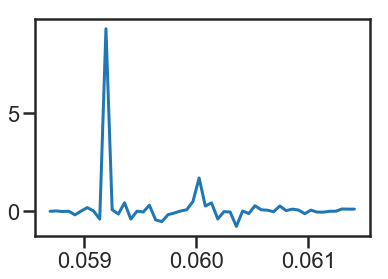

In [13]:
plt.plot(k, ds2*-1)

In [12]:
ds2*-1

array([-2.65253684e-03,  1.64314251e-02, -1.38057015e-02,  1.08701882e-03,
       -1.84747568e-01,  7.88778952e-03,  1.85935263e-01,  1.65896148e-02,
       -4.00456420e-01,  9.31708612e+00,  7.84302268e-02, -1.40480534e-01,
        4.35781872e-01, -4.01953071e-01,  3.26352820e-03, -3.78229792e-02,
        3.07727157e-01, -4.42380622e-01, -5.29302975e-01, -1.73227291e-01,
       -9.09793721e-02,  1.19961074e-02,  7.57396423e-02,  4.91179638e-01,
        1.69659580e+00,  2.66194902e-01,  4.27604128e-01, -3.94380134e-01,
       -1.95865354e-02, -3.93403691e-02, -7.74174223e-01,  1.31965155e-02,
       -1.15371724e-01,  2.83454643e-01,  7.40874740e-02,  5.32608602e-02,
       -2.34367332e-02,  2.70330747e-01,  3.10509260e-02,  1.09154114e-01,
        6.21363421e-02, -1.24998583e-01,  5.71598693e-02, -4.42847711e-02,
       -4.60922941e-02, -1.56209346e-03,  1.10550595e-03,  1.15951371e-01,
        1.07650277e-01,  1.08173804e-01])

In [ ]:
traceding = np.zeros((5, 5))

In [ ]:
f

In [ ]:
for i, _f in np.ndenumerate(f):
    print(f"{i}  {_f}")

In [ ]:
f.shape[0]

In [ ]:
f[(1,)]